In [2]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import cm, colors
%matplotlib inline
plt.rcParams.update({'figure.figsize':(7,7),'font.size':14})

import ecco_v4_py as ecco
from xmitgcm import open_mdsdataset
from dask.distributed import Client
from glob import glob
import cartopy.crs as ccrs

import os
import warnings

#### Quieting warnings and adding a diverging colorbar tool

using: http://chris35wills.github.io/matplotlib_diverging_colorbar/

In [3]:
warnings.simplefilter('ignore')
os.environ['PYTHONWARNOINGS'] = 'ignore'

# set the colormap and centre the colorbar
class MidpointNormalize(colors.Normalize):
	"""
	Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)

	e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
	"""
	def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
		self.midpoint = midpoint
		colors.Normalize.__init__(self, vmin, vmax, clip)

	def __call__(self, value, clip=None):
		# I'm ignoring masked values and all kinds of edge cases to make a
		# simple example...
		x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
		return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

### Load ECCO data

Picking up MDS formatted hourly output. This is found on **Sverdrup** in the *ivana/ecco/v4r4* directory under *scratch2*.

In [4]:
runDir = f'/scratch2/ivana/ecco/v4r4/run_c66g_pk0000204492'
dataDir = f'/scratch2/shared/ecco/v4r4'

In [5]:
%%time
ds = xr.open_mfdataset(glob(f'{dataDir}/nctiles_daily/*/*/*/*.nc'))
dgrid = xr.open_dataset(f'{dataDir}/nctiles_grid/ECCO-GRID.nc')
dgrid.load()
ds = ds.merge(dgrid)

ds

CPU times: user 377 ms, sys: 164 ms, total: 541 ms
Wall time: 608 ms


<xarray.Dataset>
Dimensions:    (i: 90, i_g: 90, j: 90, j_g: 90, k: 50, k_l: 50, k_p1: 51, k_u: 50, nv: 2, tile: 13, time: 2)
Coordinates:
  * k          (k) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
  * j          (j) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * i          (i) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * tile       (tile) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
    XC         (tile, j, i) float32 -111.60647 -111.303 ... -111.86579
    YC         (tile, j, i) float32 -88.24259 -88.382515 ... -88.07871 -88.10267
    Z          (k) float32 -5.0 -15.0 -25.0 -35.0 ... -5039.25 -5461.25 -5906.25
    timestep   (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
  * time       (time) datetime64[ns] 2015-05-01T12:00:00 2015-05-02T12:00:00
    time_bnds  (time, nv) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
  * k_p1       (k_p1) int64 0 1 2 3 4 5 6 7 8 9 ... 42 43 44 45 46 47 48 49 50
  * j_g        (j_g) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * i_g        (i_g) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * k_u        (k_u) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
  * k_l        (k_l) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
    XG         (tile, j_g, i_g) float32 -115.0 -115.0 ... -102.928925 -108.95171
    YG         (tile, j_g, i_g) float32 -88.17569 -88.31587 ... -88.02409
    CS         (tile, j, i) float32 0.06157813 0.06675376 ... -0.9983638
    SN         (tile, j, i) float32 -0.99810225 -0.9977695 ... -0.057182025
    Zl         (k_l) float32 0.0 -10.0 -20.0 -30.0 ... -4834.0 -5244.5 -5678.0
    Zu         (k_u) float32 -10.0 -20.0 -30.0 -40.0 ... -5244.5 -5678.0 -6134.5
    Zp1        (k_p1) float32 0.0 -10.0 -20.0 -30.0 ... -5244.5 -5678.0 -6134.5
    dxC        (tile, j, i_g) float32 15583.418 15588.104 ... 23406.256
    rAs        (tile, j_g, i) float32 179944260.0 180486990.0 ... 364150620.0
    rAw        (tile, j, i_g) float32 361699460.0 362790240.0 ... 364760350.0
    Depth      (tile, j, i) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    rA         (tile, j, i) float32 362256450.0 363300960.0 ... 361119100.0
    dxG        (tile, j_g, i) float32 15584.907 15589.316 ... 23142.107
    dyG        (tile, j, i_g) float32 23210.262 23273.26 ... 15595.26 15583.685
    rAz        (tile, j_g, i_g) float32 179944260.0 180486990.0 ... 364150620.0
    dyC        (tile, j_g, i) float32 11563.718 11593.785 ... 15578.138
    PHrefC     (k) float32 49.05 147.15 245.25 ... 49435.043 53574.863 57940.312
    drC        (k_p1) float32 5.0 10.0 10.0 10.0 ... 399.0 422.0 445.0 228.25
    PHrefF     (k_p1) float32 0.0 98.1 196.2 ... 51448.547 55701.18 60179.445
    drF        (k) float32 10.0 10.0 10.0 10.0 10.0 ... 387.5 410.5 433.5 456.5
    hFacS      (k, tile, j_g, i) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    hFacC      (k, tile, j, i) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    hFacW      (k, tile, j, i_g) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    maskW      (k, tile, j, i_g) bool False False False ... False False False
    maskC      (k, tile, j, i) bool False False False ... False False False
    maskS      (k, tile, j_g, i) bool False False False ... False False False
Dimensions without coordinates: nv
Data variables:
    SALT       (time, k, tile, j, i) float32 dask.array<chunksize=(1, 50, 13, 90, 90), meta=np.ndarray>
    THETA      (time, k, tile, j, i) float32 dask.array<chunksize=(1, 50, 13, 90, 90), meta=np.ndarray>
Attributes:
    product_time_coverage_start:  1992-01-01T12:00:00
    author:                       Ou Wang and Ian Fenty
    Insitution:                   JPL
    product_version:              ECCO Version 4 Release 3 Extension (ECCOv4r...
    time_units:                   days since 1992-01-01 00:00:00
    Conventions:                  CF-1.6
    Project:                      Estimating the Circulation and Cl

### Sanity checks

Plotting global bathymetry.

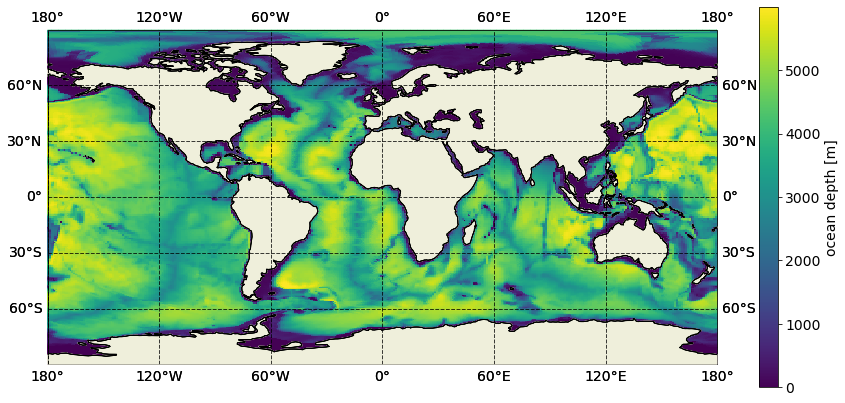

In [6]:
plt.figure(figsize=(15,7))
ecco.plot_proj_to_latlon_grid(ds.XC,ds.YC,ds.Depth,
                              projection_type='PlateCarree',
                              user_lon_0=0,
                              show_colorbar=True);

### Find the subset

Isolate the subset based on the data provided from [OOI](https://ooinet.oceanobservatories.org). 

Compare **ECCO** over five **PIONEER** profiler moorings off the coast of New England. We will get as close as possible to get similar T,S profiles. I am using hourly output from **ECCO**. 

In [7]:
#             'name': [XC:lon,    YC:lat]
CTD_coords = {'OSPM': [-70.88033, 39.93556], \
              'PMUO': [-70.78037, 39.94120], \
 #             'PMUI': [-70.78035, 40.36490], \
              'PMCO': [-70.88768, 40.10123], \
              'PMCI': [-70.88893, 40.22695]    }

# Get array of 1's at range of latitudes and longitudes
ones = xr.ones_like(ds.YC)
dome_maskC = ones.where( (ds.YC>=38) &  (ds.YC<=41.75) & (ds.XC>=-75.5) & (ds.XC<=-70), 0)

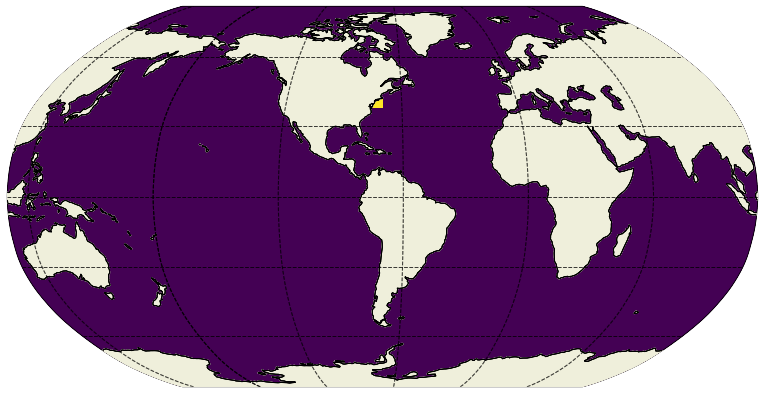

In [8]:
plt.figure(figsize=(15,7))
ecco.plot_proj_to_latlon_grid(ds.XC,ds.YC,dome_maskC,
                              user_lon_0=-70);

In [9]:
print('Data could be contained in:')
for i in range(13):
    if (np.count_nonzero(dome_maskC.isel(tile=i).values) != 0):
        print ('tile %i' %i)
        
dTile = [10]

Data could be contained in:
tile 10


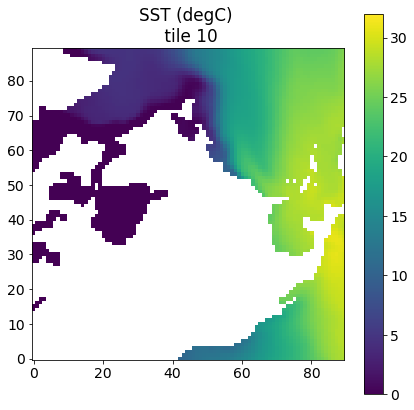

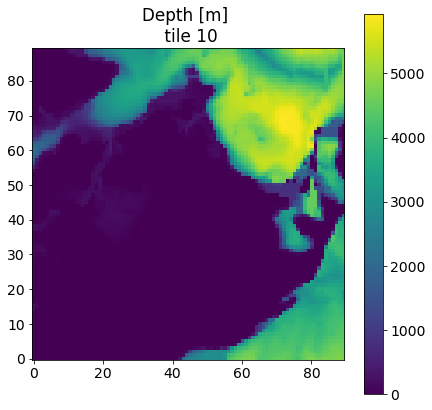

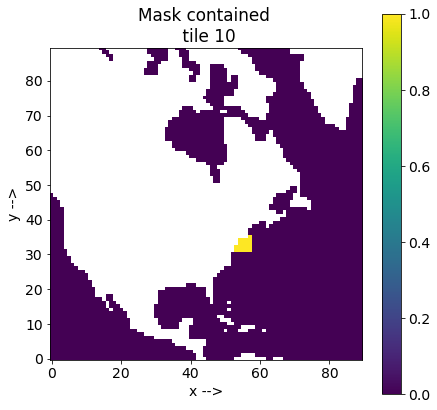

In [10]:
tile_to_plot= ds.THETA.isel(k=0,time=0,tile=10).where(ds.hFacC.isel(tile=10,k=0) !=0, np.nan)

# Step 2, use plt.imshow()
plt.figure()
plt.imshow(tile_to_plot, origin='lower');

# Step 3, add colorbar, title, and x and y axis labels
plt.colorbar()
plt.clim([0,32])
plt.title('SST (degC) \n tile %i'%10)
plt.show()

#######

tile_to_plot= ds.THETA.isel(k=0,time=0,tile=10).where(ds.hFacC.isel(tile=10,k=0) !=0, np.nan)

# Step 2, use plt.imshow()
plt.figure()
plt.imshow(tile_to_plot.coords["Depth"], origin='lower');

# Step 3, add colorbar, title, and x and y axis labels
plt.colorbar()
#plt.clim([0,32])
plt.title('Depth [m] \n tile %i'%10)
plt.show()

plt.figure()
# Step 1, select the tile to plot using the **.isel( )** syntax.
tile_to_plot=dome_maskC.isel(tile=10).where(ds.hFacC.isel(tile=10,k=0) !=0, np.nan)

# Step 2, use plt.imshow()
plt.imshow(np.rot90(tile_to_plot), origin='lower');

# Step 3, add colorbar, title, and x and y axis labels
plt.colorbar()
plt.title('Mask contained \n tile 10')
plt.xlabel('x -->')
plt.ylabel('y -->')
plt.show()

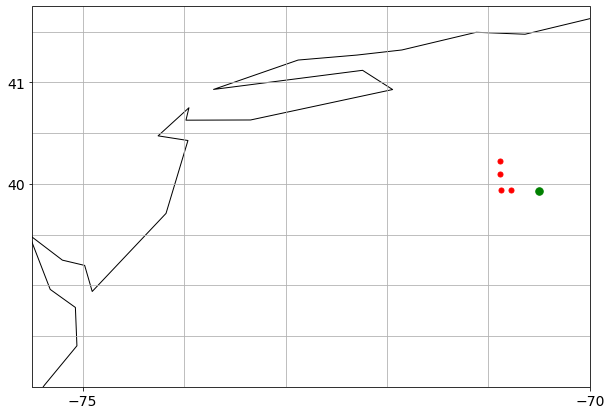

In [11]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines('110m')
ax.gridlines()

for _,pos in CTD_coords.items():
    ax.plot(pos[0],pos[1],'r.',markersize=10)
ax.plot(-70.5, 39.93, 'g.', markersize=15)
    
ax.set_xticks([-75, -70], crs=ccrs.PlateCarree())
ax.set_yticks([40, 41], crs=ccrs.PlateCarree())
ax.set_extent([-75.5, -70, 38, 41.75])

plt.show()

### Find the local indices on Tile 10

We find indices **i**,**j** for each of the five mooring points. To do this we take the smallest Euclidean distance from the point desired. (Can make better by using shortest great circle distance)

https://stackoverflow.com/questions/36798782/how-to-query-the-nearest-neighbors-including-the-ones-at-distance-zero-with-scip
https://stackoverflow.com/questions/34812372/interpolate-unstructured-x-y-z-data-on-best-grid-based-on-nearest-neighbour-dist

In [12]:
from scipy.spatial import cKDTree
Tile10 = np.stack([ds.XC.sel(tile=10).values.flatten(), \
                   ds.YC.sel(tile=10).values.flatten()]).T

In [13]:
J=[]; I=[]
for key in CTD_coords:
    _, ii = cKDTree(Tile10).query([ CTD_coords[key][0],\
                                    CTD_coords[key][1] ], k=1)
    print(Tile10[ii])
    
    iVal=np.where(ds.YC.sel(tile=10).values == Tile10[ii][1])
    jVal=np.where(ds.XC.sel(tile=10).values == Tile10[ii][0])
    J.append( jVal[0][0] )
    I.append( iVal[1][0] )
print(J,I) 

[-70.5      39.92998]
[-70.5      39.92998]
[-70.5      39.92998]
[-70.5      39.92998]
[57, 57, 57, 57] [56, 56, 56, 56]


We map the flattened index values above (not sure if these are exactly the global indices) with the local index values of Tile 10.

We create a truncated **xarray.DataArray** for the temperature at all of the closest **ECCO** grid points.

In [14]:
zMax = ds.sel(tile=10, i=I[0], j=J[0]).Depth
kMax=24
print(zMax.values)

pioneerDs = ds.sel(k=slice(0,kMax), i=I[0],j=J[0],tile=10, time='2015-05-01')

659.848


## Plot bathymetry and array info

Make plot with bathymetry in region of interest.

Add dots for each profiler used + add label

Add dot for ECCOv4r4 point + add label

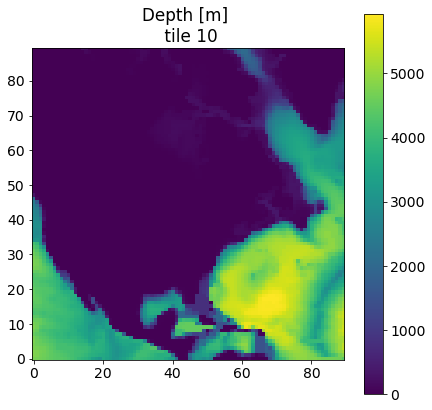

In [15]:
tile_to_plot= ds.THETA.isel(k=0,time=0,tile=10).where(ds.hFacC.isel(tile=10,k=0) !=0, np.nan)

# Step 2, use plt.imshow()
plt.figure()
plt.imshow(np.rot90(tile_to_plot.coords["Depth"]), origin='lower');

# Step 3, add colorbar, title, and x and y axis labels
plt.colorbar()
#plt.clim([0,32])
plt.title('Depth [m] \n tile %i'%10)
plt.show()

<sub> Written by Escobar, I. 13 October 2020 </sub>